In [14]:
import numpy as np
import matplotlib.pyplot as plt
from linalg_helper import make_random_direction, make_random_subspace, simulate_free_response
from functools import reduce
from plot_helper import plot_histogram

def make_linear_diag(big, diff, dim):
    return np.diag([big - diff * i for i in range(dim)])

def make_onebig_restsame_diag(big, small, dim):
    return np.diag([big] + [small] * (dim - 1))

def make_mult_diag(big, scale, dim):
    return np.diag([big *(scale)**i for i in range(dim)])

def perturb_vector(v, dot_prod, dim):
    v = v.reshape((dim, 1))
    d = make_random_direction(dim).reshape((dim, 1))
    orth = d - d.T.dot(v)*v
    orth = orth/np.linalg.norm(orth)
    return dot_prod * v + np.sqrt(1.0 - dot_prod ** 2) * orth

def vec_dot():
    return np.linalg.eigh(make_peturb_mat(Ab, 1))

def make_peturb_mat(A, num_obs):
    d = make_random_subspace(dim, num_obs)
    D = d @ d.T
    if num_obs == 1:
        D = l1 * np.outer(v1, perturb_vector(v1, 0.9, dim))
    return A - D

dim = 10;
Q = make_random_subspace(dim, dim)
A = make_onebig_restsame_diag(20, 0.9, dim)
Ab = Q @ A @ Q.T
l1 = A[0,0]
v1 = np.reshape(Q[:,0], (dim, 1))

x_init = make_random_direction(dim)

In [3]:
# The issue I suspect from using the y[t] to make an eigenvector combination will be that it'll be difficult
# The variability in the y[t] from the actual lambda^t * d[t] * x[0] will mess things up


# maybe a function/colormap that looks at whether or not it decays as a function of run_length, error, etc.
mats = []
run_length = 1000

v_est = perturb_vector(v1, 0.9999)

for _ in range(run_length):
    mats.append(Ab - l1 * np.outer(v_est, perturb_vector(v1, 0.99)))
    
prod_A = reduce(lambda x, y: y @ x, mats)
max_singular_val = np.linalg.norm(prod_A,ord=2)
if max_singular_val < 1:
    print('Decays')
else:
    print('Doesn''t decay')
print(max_singular_val)

Decays
1.2874921372335509e-45


In [420]:
d = make_random_direction(dim)
D = np.outer(v1,v1)
print(np.linalg.norm(Ab, ord=2))
print(np.linalg.norm(D, ord=2))
print(np.linalg.norm(Ab @ (np.eye(dim) - D), ord=2))

19.999999999999993
1.0
10.0


In [325]:
D = make_random_subspace(dim, 1)
print(D.T @ v1)
print(np.linalg.norm(D.T @ v1))

[[-0.31503455]]
0.3150345461304669


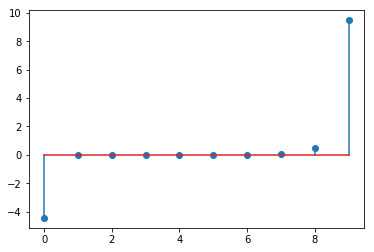

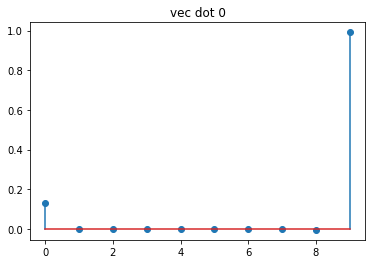

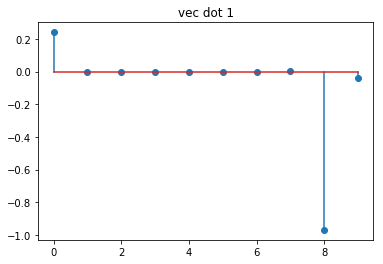

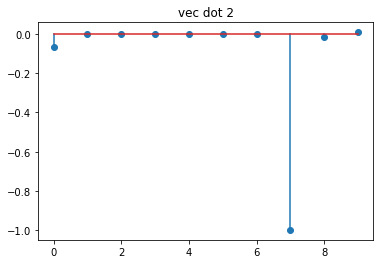

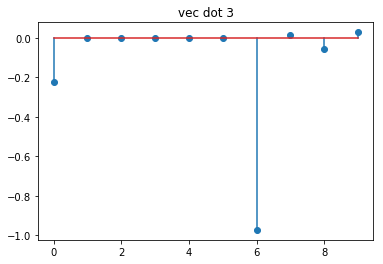

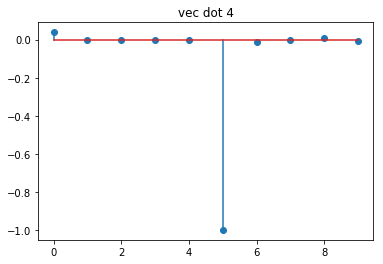

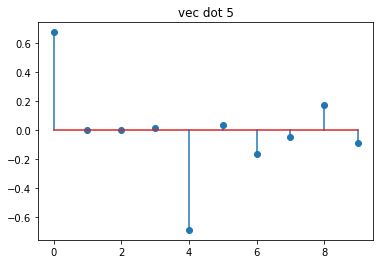

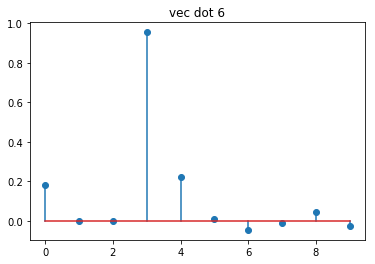

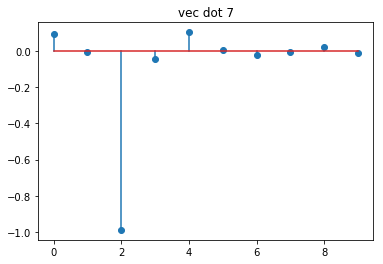

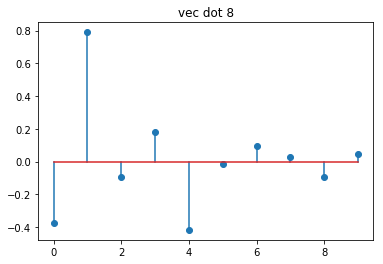

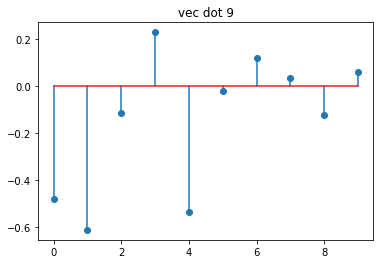

In [129]:
#interesting simulations to try:
# 1. when eigenvalues are all the same (identity scaled by a value)
# 2. When eigenvalues are one big, a bunch of small
# 3. When eigenvalues are linearly decreasing
# 4. When eigenvalues are multiplicatively (log linearly) decreasing
# 5. When the observations are more than just one observation
# 6. When perturbations are not just dd^T, and are some vector * d^T, or some scaling as well

eig_list = []
for _ in range(1):
    eig_list.append(vec_dot())
    
eig_list = list(zip(*eig_list))

for e_arr in eig_list[0]:
    fig, ax = plt.subplots()
    ax.stem(e_arr)

for e_vecs in eig_list[1]:
    #print(e_vecs.T @ v1)
    for i in range(dim):
        fig, ax = plt.subplots()
        ax.stem(e_vecs.T @ Q[:,i])
        ax.set_title('vec dot {0}'.format(i))
#print(eig_list[0])

In [18]:
# Can we do anything if we have magnitude information?

x_trace = []
y_trace = []
proj_trace = []

def trace_gen():
    x_trace.append(x_init)
    d1 = make_random_direction(dim)
    y_trace.append(x_init @ d1)
    x_trace.append(A @ x_init)
    d2 = make_random_direction(dim)
    y_trace.append(x_trace[-1] @ d2)
    proj_trace.append((y_trace[-1]-y_trace[-2]) * d2)
    for _ in range(1000):
        x_trace.append(A @ x_trace[-1])
        d1 = d2
        d2 = make_random_direction(dim)
        y_trace.append(x_trace[-1] @ d2)
        proj_trace.append((y_trace[-1]-y_trace[-2]) * d2)

trace_gen()

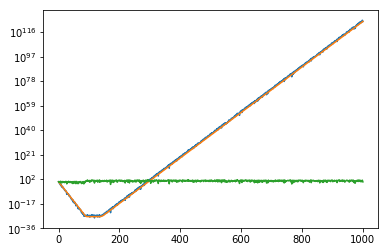

In [248]:
plt.plot(np.abs(y_trace))
#plt.plot(np.mean(np.abs(proj_trace), axis=1))
plt.plot(np.mean(x_trace, axis=1))
plt.plot(np.divide(np.abs(y_trace),np.mean(x_trace, axis=1)))
plt.yscale('log')

/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


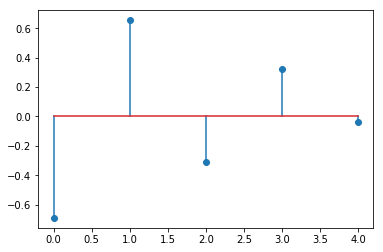

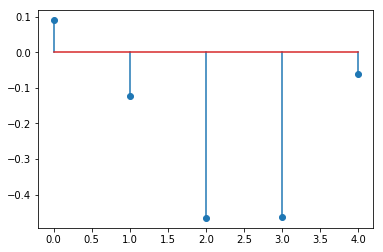

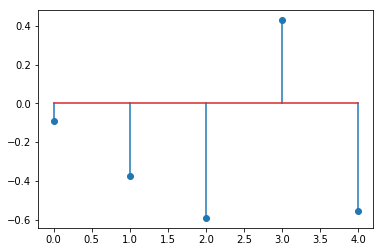

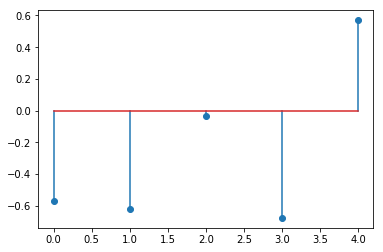

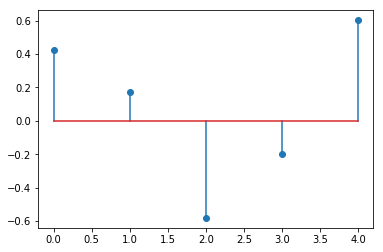

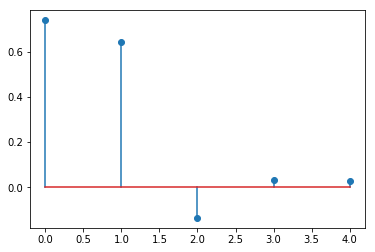

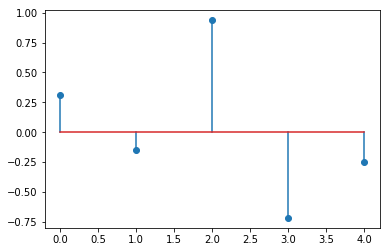

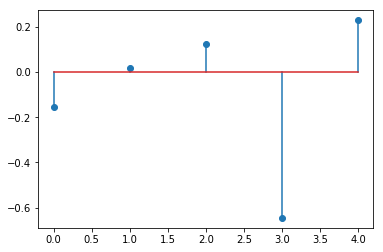

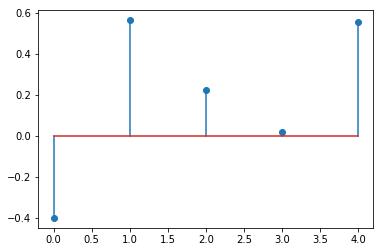

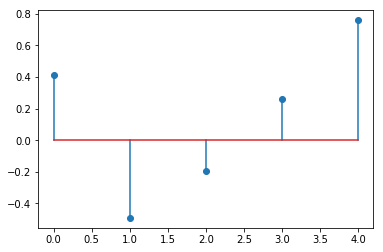

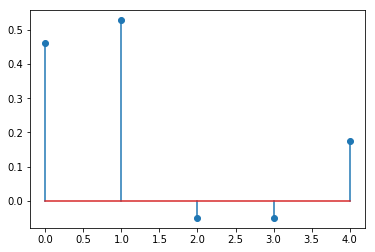

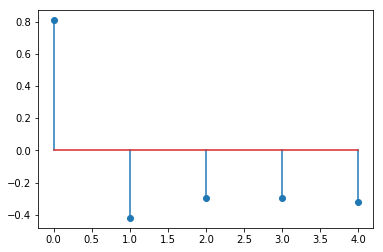

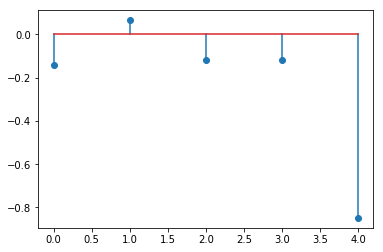

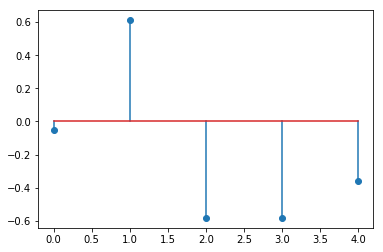

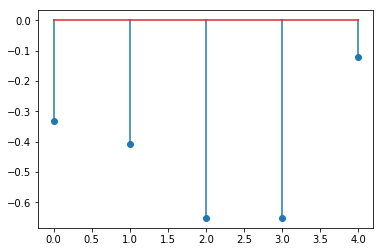

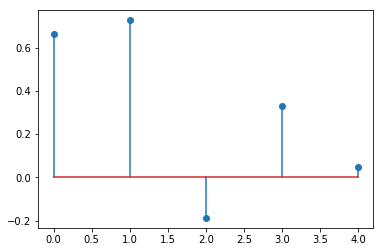

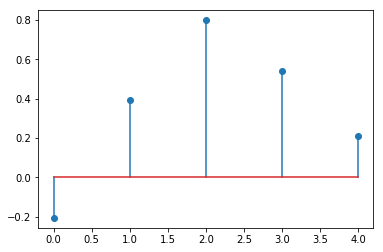

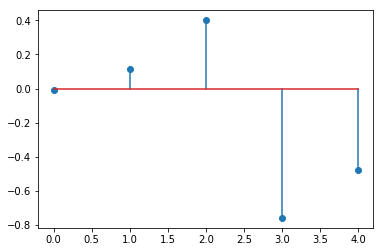

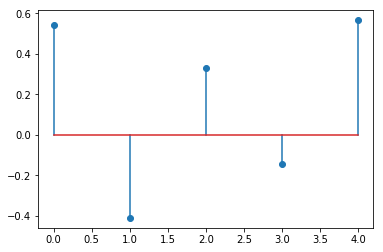

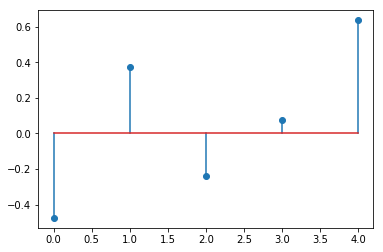

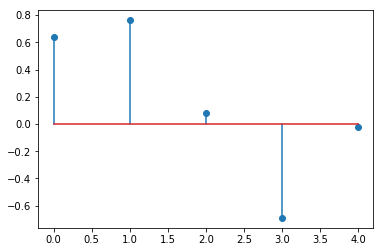

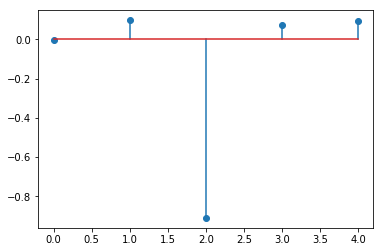

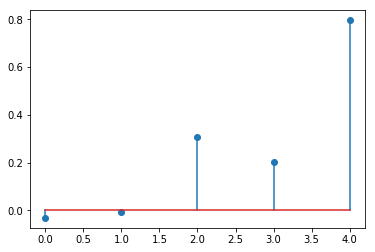

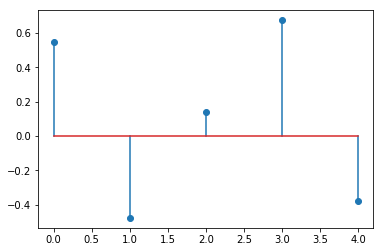

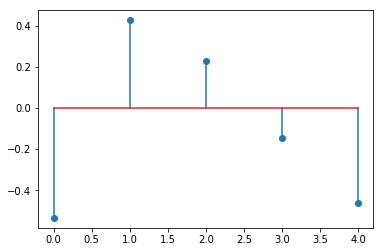

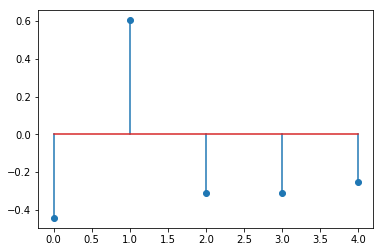

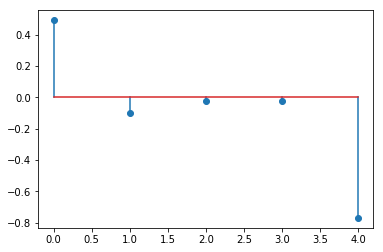

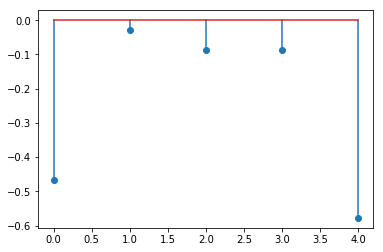

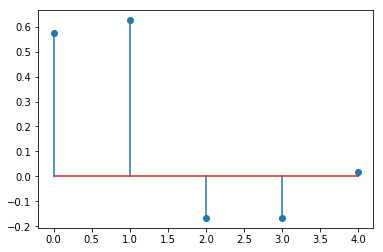

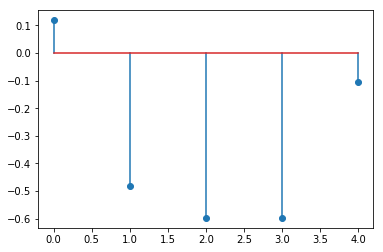

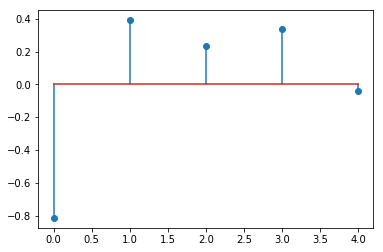

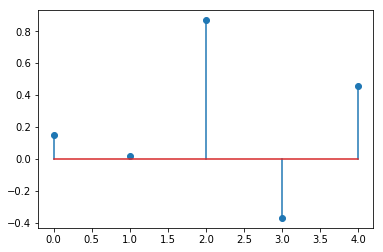

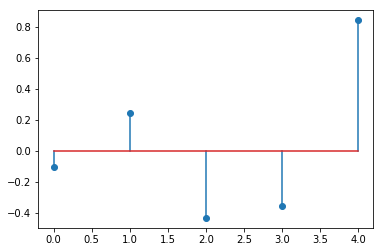

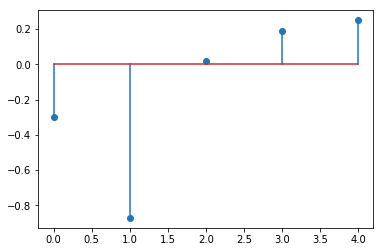

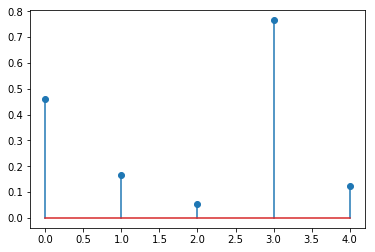

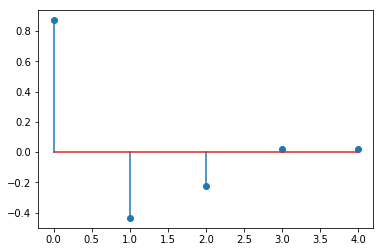

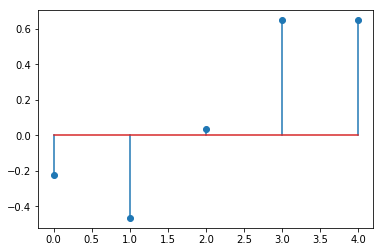

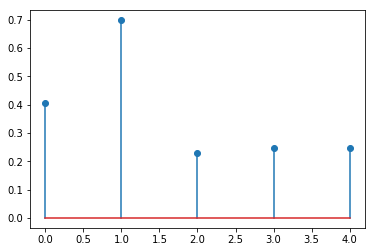

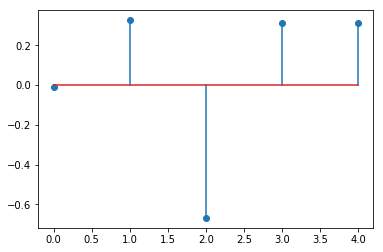

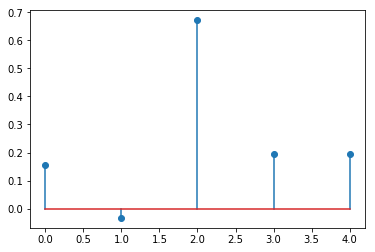

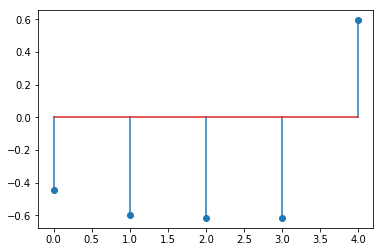

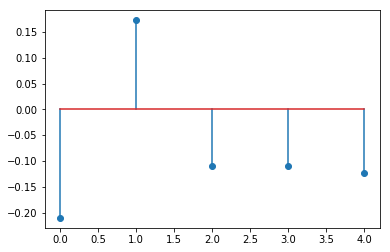

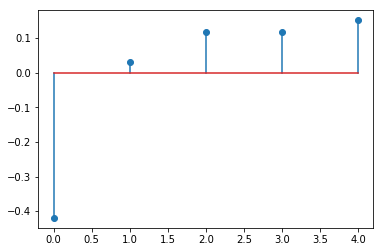

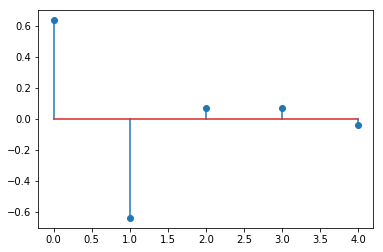

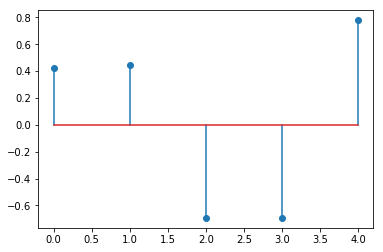

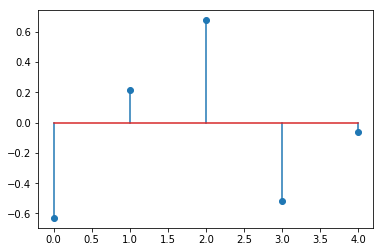

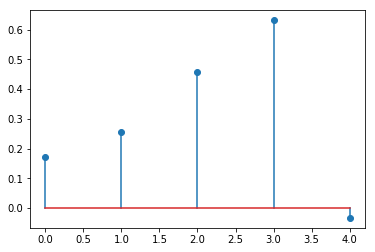

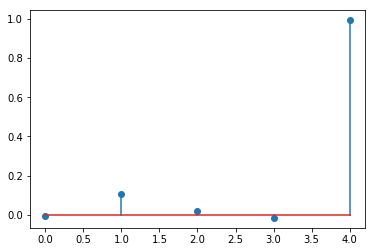

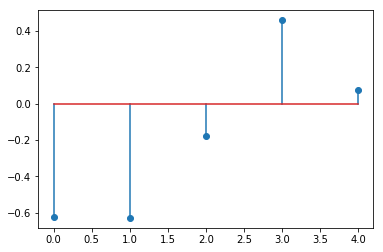

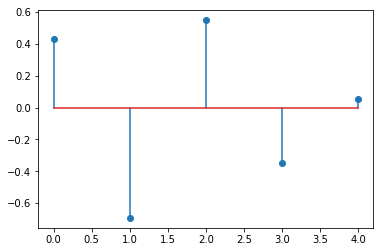

In [33]:
def eigs():
    d = make_random_subspace(dim,1)
    #Q = make_random_subspace(dim,dim)
    V = np.eye(dim)
    v = Q[:,0]
    D = 1.5*d@d.T #np.outer(d, d)
    avg = np.mean(A)
    return np.linalg.eig( Q@A@Q.T - D)

# Take away seems to be that you have a probabalistic chance of hitting the right eigenvalue. 1 observation direction is one out of many
# The eigenvalue can be split in effect (into different dimensional buckets)

eigs_l = []

for _ in range(10):
    eigs_l.append(eigs())
    #print(eigs_l[_][1])
    for v in eigs_l[_][1]:
        fig, ax = plt.subplots()
        ax.stem(v)

Let's try examining the error from simulation between trying to compose v1 from y[t] and lambda for control purposes.

(Also, I wonder if perturbations to non-normal matrices don't make eigenvalues jump more wildly, and possibly in a stabilizing way. How can we make them attract? If poles repel or attract, can a certain feedback laws with observations create 'zeros' that push or pull the poles in the frequency domain? Can we think of this as the dynamics of the poles themselves when observations are used a certain way creating certain zeroes, and we want them on average inside the unit circle? Actually, eigenvectors matter too, so maybe this perspective is not all that useful.)

The strategy is as follows: The state matrix, if using feedback with the single measurement $y[t]$ is essentially
$$A\vec{x}[t] - \vec{k}y[t] = \left(A -\vec{k}\vec{d}^T[t]\right)\vec{x}[t]$$

The new transition matrix is thus $A -\vec{k}\vec{d}^T[t]$

However, this fails because attempting to move the largest eigenvalue amounts to trying to zeroing out the $\lambda_1\vec{v_1}\vec{v_1}^T$ term blindly. If we have knowledge of the eigenvector and eigenvalue, at most we can choose $\vec{k} = \lambda_1\vec{v_1}$ if using this feedback law.

So how can we control the $\vec{d}^T[t]\vec{x}[t]$ component? At best, we can sum or leverage the following: $\vec{d}^T[t]\vec{x}[t] + \cdots + \vec{d}^T[t+n]\vec{x}[t+n] = y[t] + \cdots + y[t+n]$, which is leveraging information from the past. If we can estimate $\vec{x}[t+n]$ in terms of $\vec{x}[t]$, we stand a chance of using past measurements at the current time step. Since we are interested particularly in stabilizing the largest eigenvalue, we can approximate our system state as being mostly aligned with the largest eigenvector. So this is precisely what we can try, where we compose the various $\vec{d}[t]$ into the desired eigenvector.

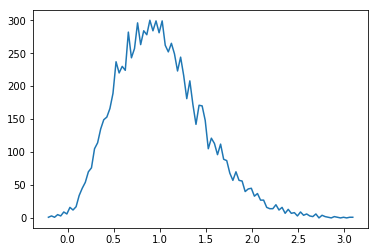

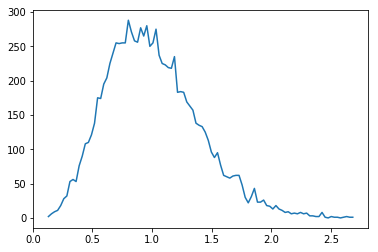

In [564]:
def blah():
    trials = 1;
    dim = 10;
    N = 10;
    Q = make_random_subspace(dim, dim)
    A = make_onebig_restsame_diag(1.1, 0.9, dim)
    Ab = Q @ A @ Q.T
    l1 = A[0,0]
    v1 = np.reshape(Q[:,0], (dim, 1))

    x_init = perturb_vector(v1, 0.5).reshape((1, dim))
    x_init_align = v1.reshape((1, dim))

    x_free = simulate_free_response(Ab, N, x_init)
    x_free_align = simulate_free_response(Ab, N, x_init_align)

    obs_vecs = np.array([make_random_direction(dim) for i in range (N*trials)])
    obs = np.array([np.einsum('ij,ij->i', obs_vecs[N*i:N*(i+1), :], x_free) for i in range (trials)])
    obs_align = np.array([np.einsum('ij,ij->i', obs_vecs[N*i:N*(i+1), :], x_free_align) for i in range (trials)])
    #plt.plot(np.divide(obs,obs_align).T)

    coords = obs_vecs[:10,:] @ v1
    coeffs = (l1 ** 9) * np.array([obs[:,i]/(l1 ** i) for i in range(10)])
    coeffs_align = (l1 ** 9) * np.array([ obs_align[:,i]/(l1 ** i) for i in range(10)])
    est_state_dot = coeffs.T @ coords
    est_state_dot_align = coeffs_align.T @ coords
    state_dot = x_free[9,:] @ v1
    state_dot_align = x_free_align[9,:] @ v1
    return np.divide(est_state_dot, state_dot)[0][0], np.divide(est_state_dot_align, state_dot_align)[0][0]

# implement this as a control law
#print('State dotted with eigvec: {0}'.format(np.divide(est_state_dot, state_dot)))
#print('State dotted with eigvec, aligned: {0}'.format(np.divide(est_state_dot_align, state_dot_align)))

L = [blah() for _ in range(10000)]
L = list(zip(*L))

plot_histogram(L[0], 100)
plot_histogram(L[1], 100)
#print(L)

[0.10601402]


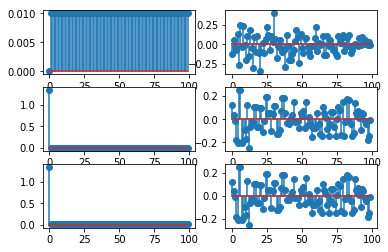

In [49]:
def trial(A, dim, des_dot_prod, print_out = True):
    """
    Returns 3 matrices
    1 - ideal matrix with largest eigenvalue subtracted out
    2 - matrix with estimated subtraction, start x[0], initial state aligned
    3 - matrix with estimated subtraction, start x[0], initial state not aligned
    4 - matrix with estimated subtraction, end x[dim-1], initial state aligned
    5 - matrix with estimated subtraction, end x[dim-1], initial not state aligned
    
    Estimation occurs with perfect eigenvalue and eigenvector knowledge
    """
    # Generate state transition matrix A
    Q = make_random_subspace(dim, dim)
    Ab = Q @ A @ Q.T
    l1 = A[0,0]
    v1 = np.reshape(Q[:,0], (dim, 1))
    
    # A - lambda * vv^T
    ret_mat1 = Ab - l1 * np.outer(v1, v1)
    
    # x[0]
    x_init = perturb_vector(v1, des_dot_prod, dim).reshape((1, dim))
    x_init_align = v1.reshape((1, dim))
    
    # x[0], ..., x[dim - 1]
    x_free = simulate_free_response(Ab, dim, x_init)
    x_free_align = simulate_free_response(Ab, dim, x_init_align)

    # d[0], ..., d[dim-1]
    obs_vecs = np.array([make_random_direction(dim) for i in range(dim)])
    
    # y[0], ..., y[9]
    obs = np.einsum('ij,ij->i', obs_vecs, x_free)
    obs_align = np.einsum('ij,ij->i', obs_vecs, x_free_align)
    
    # There are coordinates of v1 in terms of d[t], which can be used to reconstitute v1
    # a_1 = d[0]^T v1 , ..., a_n = d[dim-1]^T v1
    
    # Estimate coordinates using observations for state x[dim-1]
    # a^_t = y[t]*lambda^(dim-1-t) ~= d[t]^T x[t] * lambda^(dim-1-t) ~= d[t]^T x[dim-1]
    lambda_pows = np.logspace(dim-1, 0, num = dim, base=l1)
    coeffs_end = np.multiply(obs, lambda_pows[::-1])
    coeffs_align_end = np.multiply(obs_align, lambda_pows[::-1])

    v1_hat3 = obs_vecs.T @coeffs_end.T
    v1_hat4 = obs_vecs.T @coeffs_align_end.T
    
    # Normalize vectors (turn this on and off?) Maybe try normalizing according to how much is in there?
    # is this actually doable in terms of the calculations before injecting our control input?
    # can we orthogonalize?
    # can we look at stability?

    v1_hat3 /= np.linalg.norm(v1_hat3)
    v1_hat4 /= np.linalg.norm(v1_hat4)
    
    if print_out:
        print(v1_hat4.dot(v1))

    # Reconstitute v1^ using estimated a^_t
    ret_mat2 = Ab - l1 * np.outer(v1, v1_hat3)
    ret_mat3 = Ab - l1 * np.outer(v1, v1_hat4)
        
    return ret_mat1, ret_mat2, ret_mat3

fig, axs = plt.subplots(3, 2)
tr = trial(make_onebig_restsame_diag(1.5,0.01, 100), 100, 1)

for i in range(3):
    lambds, vecs = np.linalg.eig(tr[i])
    ind = np.argmax(lambds)
    if i == 0:
        ind = np.argmin(lambds)
    axs[i,0].stem(lambds)
    axs[i,1].stem(vecs[ind])

Feels like this strategy will fail because
1. Eigenvectors of perturbation aren't neccessarily aligned
2. As soon as we kill off the large part, if the other parts are unstable, then that's what we see, so we don't see the same growth trend, and see the next largest eigenvalue. Additionally, since we have to wait for the component
3. The assumption of growth only along the eigenvector is fundamentally wrong.